In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

In [2]:
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000
cache_dir="..\\data\\"
max_hist_dist = 2_000_000
require_in_col = False
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = 'minnie65_phase3_v1'
client = CAVEclient(datastack_name)
# client.auth.get_new_token()  <-- use this the first time to get a token

## Find a layer 2/3 pyramidal cell that's been proofread to investigate

In [662]:
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
proofreading_status = pd.DataFrame(client.annotation.get_annotation('proofreading_status_public_release', range(1000)))
proofread_cells = proofreading_status.query("status_axon == 'extended' and status_dendrite == 'extended'")
P23_cells = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1', filter_equal_dict={"cell_type": "23P"})
# proofread_cells = client.materialize.query_table('proofreading_functional_coreg_v2')
to_study = set.intersection(set(P23_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique()))
len(to_study)

20

In [1271]:
# cell_root_id = 864691136273790989  # inhibitory neuron Nuno sent me
# cell_root_id = 864691135293126156  # Nuno's first P23 cell
cell_root_id = to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
cell_root_id, to_study

(864691134988768122, set())

In [1272]:
cell_data = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1', filter_equal_dict={'pt_root_id': cell_root_id})
if len(cell_data) != 1 or cell_data.cell_type.iloc[0] != "23P":  # just to double check
    raise ValueError("Input cell must not be falsely merged and must be excitatory")
root_point = cell_data['pt_position'].iloc[0]
nucleus_id = cell_data['id'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,294657,t,aibs_coarse_excitatory,23P,89941014164582084,864691134988768122,"[183104, 133760, 22248]"


### Set up storage of results

In [1273]:
results_dict = {"parameters": {"max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "require_in_col": require_in_col}}
results_fname = str(cell_root_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
results_dir = os.path.join(cache_dir, "results", "dendrite-clean-subclass")
results_path = os.path.join(results_dir, results_fname + ".json")

In [1274]:
# bounding box of the column we're interested in
# bbox = [[ 672444, 200000, 805320], [ 772444, 1294000, 905320]]  # nm
resolution = np.array([4., 4., 40.])
# bbox = [[ 672444 // 4, 200000 // 4, 805320 // 40], [ 772444 // 4, 1294000 // 4, 905320 // 40]]  # vx
# def in_bbox(p):
#     """ returns whether point is between the two points given by bbox"""
#     lower, upper = bbox
#     return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

all_cells = client.materialize.query_table('allen_soma_coarse_cell_class_model_v1')
# col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]
# col_cells

## Get the neuron

In [1275]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(cell_root_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(cell_root_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < 0.5:
    raise ValueError("Axon may not have been found")
split_quality

Loading neuron from cache... successful.


0.8657463681578552

In [1276]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

# these ones are mislabeled as input synapses
false_input_df = nrn.anno.post_syn.df
false_input_df["skel_idx"] = nrn.anno.post_syn.mesh_index.to_skel_index_padded
false_input_df = false_input_df[nrn.anno.is_axon.mesh_mask[false_input_df.post_pt_mesh_ind]] # some synapses in post_syn are actually on the axon, and should be included
# swap pre and post columns because these synapses were falsely labelled as input synapses
false_input_df["post_pt_position"], false_input_df["pre_pt_position"] = false_input_df["pre_pt_position"], false_input_df["post_pt_position"]
false_input_df["post_pt_root_id"], false_input_df["pre_pt_root_id"] = false_input_df["pre_pt_root_id"], false_input_df["post_pt_root_id"]
# rename these two columns
false_input_df["pre_pt_mesh_ind"], false_input_df["pre_pt_level2_id"] = false_input_df["post_pt_mesh_ind"], false_input_df["post_pt_level2_id"]
del false_input_df["post_pt_mesh_ind"], false_input_df["post_pt_level2_id"]
false_input_df["post_pt_supervoxel_id"], false_input_df["pre_pt_supervoxel_id"] = false_input_df["pre_pt_supervoxel_id"], false_input_df["post_pt_supervoxel_id"]
false_input_df.head()

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,pre_pt_mesh_ind,pre_pt_level2_id
58,"[189360, 216762, 23940]",182762248,"[189336, 216734, 23941]",864691133736148018,90796571851476985,"[189336, 216734, 23941]",864691133736148018,90796571851476985,240,t,4163,8949,162854165888893249
226,"[223092, 139797, 20783]",236972903,"[223038, 139776, 20788]",864691135132563749,95430600642909920,"[223038, 139776, 20788]",864691135132563749,95430600642909920,316,t,6478,13296,167488194680455661
516,"[242590, 126988, 17581]",267869265,"[242522, 126946, 17584]",864691136001845896,98102894531986017,"[242522, 126946, 17584]",864691136001845896,98102894531986017,2860,t,7068,14106,170160488569634888
690,"[182774, 140796, 22231]",167820482,"[182778, 140762, 22233]",864691136720499566,89871607493060409,"[182778, 140762, 22233]",864691136720499566,89871607493060409,1604,t,3017,6203,161929201530700287
701,"[185909, 173326, 22257]",175416150,"[185852, 173282, 22267]",864691135581803629,90298218004660047,"[185852, 173282, 22267]",864691135581803629,90298218004660047,1436,t,3663,7688,162355812042277439


In [1277]:
output_df = pd.concat([output_df, false_input_df], axis=0).reset_index(drop=True)

In [1278]:
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id

## Clean the data further

In [1279]:
# not falsely merged (this can be sped up in some cases by changing all_cells to col_cells)
include = np.array([sum(all_cells.pt_root_id == root_id) == 1 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()

if len(clean_output_df.post_pt_root_id) == 0:  # skip if no clean connections
    print("No clean connections")
    with open(results_path, "w") as f:
        f.write(json.dumps(results_dict))
    # todo: return 

# Count its synapse types

In [1280]:
# # Look at a pyramidal neuron, count its synapse types

def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is 23P:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_23P"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 758
post syn BPC proportion given pre is 23P: 0.030343007915567283
n = 758
post syn BC proportion given pre is 23P: 0.17678100263852242
n = 758
post syn MC proportion given pre is 23P: 0.10949868073878628
n = 758
post syn NGC proportion given pre is 23P: 0.011873350923482849


## Soma-to-soma distance

In [1281]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = all_cells.query(f"pt_root_id == {post_id}")
    if len(possible) > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if len(possible) == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position.iloc[0])
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,soma_to_soma_dist
1,"[181364, 133712, 26033]",167308498,"[181330, 133770, 26041]",864691135373903602,89729908402034650,161787502439432863,5875,"[181434, 133688, 26025]",864691134988768122,89729908402009084,10312,t,2881,185582.688848
2,"[290632, 195902, 24610]",354038633,"[290704, 195926, 24614]",864691135207783033,104726834553366652,176784428591218747,14907,"[290602, 195884, 24610]",864691134988768122,104726834553361580,5228,t,7654,554226.029443
3,"[291992, 129474, 18670]",349573638,"[291934, 129500, 18667]",864691135937600821,104929006448841635,176986600486470121,14999,"[292042, 129482, 18670]",864691134988768122,104929006448854410,41400,t,7718,448220.307046
4,"[185538, 216624, 24137]",176746859,"[185584, 216658, 24139]",864691135837451155,90303990708951260,162361584746758303,7717,"[185626, 216636, 24137]",864691134988768122,90303990708946717,11484,t,3700,299287.827965
7,"[184378, 218296, 24341]",176923937,"[184434, 218324, 24332]",864691135926514644,90163528098713340,162150753392132682,7038,"[184352, 218360, 24341]",864691134988768122,90093159354534321,8900,t,3311,377249.911014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,"[125858, 140602, 22890]",64865971,"[125804, 140668, 22886]",864691135407321289,82060676956609567,154118270994088560,184,"[125908, 140608, 22888]",864691134988768122,82060676956614576,2996,t,148,237982.666125
1380,"[156134, 113528, 23077]",121512610,"[156164, 113568, 23076]",864691137019673454,86208790797560281,158266384835413180,870,"[156178, 113492, 23080]",864691134988768122,86208790797559303,5840,t,607,133604.736682
1381,"[197868, 134414, 20722]",193817485,"[197870, 134464, 20726]",864691136965758414,91981844983348928,164039439020983340,11291,"[197810, 134434, 20726]",864691134988768122,91981844983349972,948,t,5268,128665.476333
1386,"[185909, 173326, 22257]",175416150,"[185852, 173282, 22267]",864691135581803629,90298218004660047,162355812042277439,7688,"[185852, 173282, 22267]",864691135581803629,90298218004660047,1436,t,3663,164699.188000


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [1282]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Path-length

In [1283]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [1284]:
clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [1285]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]

In [1286]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
nsteps = 1000
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step

In [1287]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [1288]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return dict([(k, d[k].tolist()) for k in d])
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [1289]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

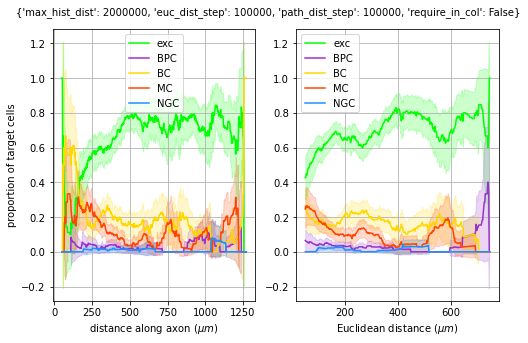

In [1290]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    sem = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * sem, p + 2 * sem, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [1291]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

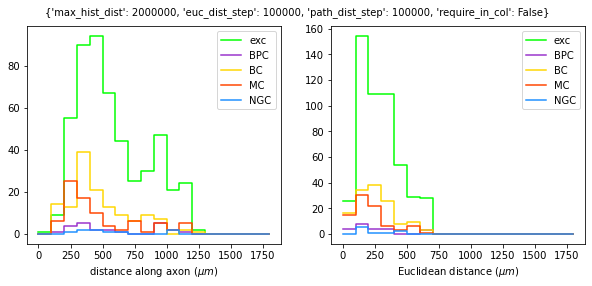

In [1292]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [1293]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

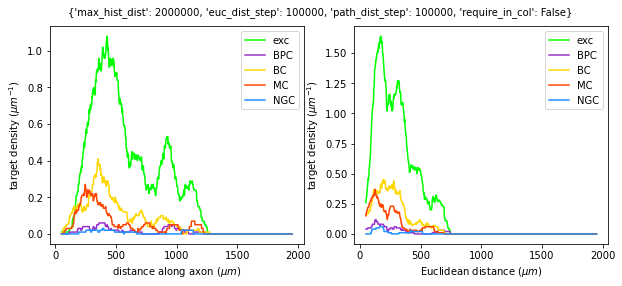

In [1294]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [1295]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

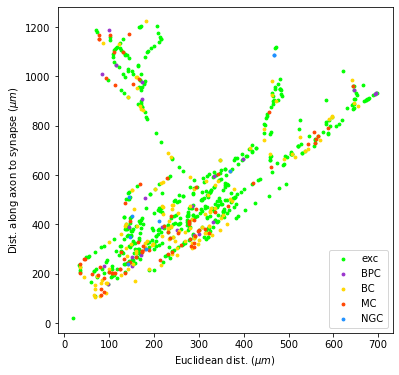

In [1296]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

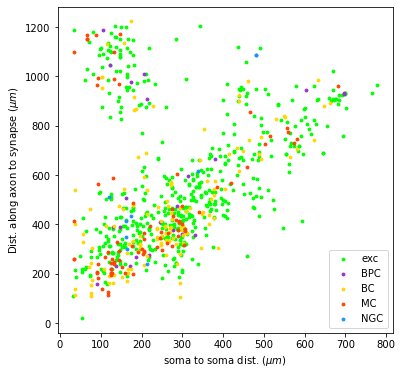

In [1297]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [1298]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

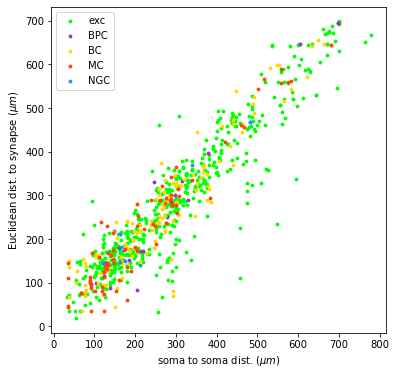

In [1299]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [1300]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

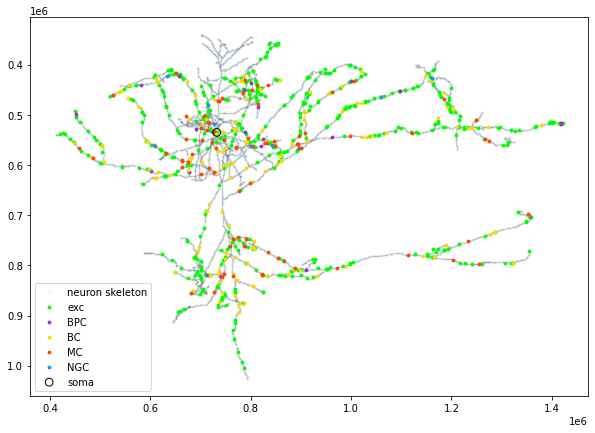

In [1301]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

In [1302]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))